In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import glob
folder_path = "C:\\Users\\Bulat\\Desktop\\Proga\\Контесты\\Яндекс\\Биометрия\\train\\*.wav"
audio_files = glob.glob(folder_path)

In [3]:
audio_files[:5]

['C:\\Users\\Bulat\\Desktop\\Proga\\Контесты\\Яндекс\\Биометрия\\train\\0006238dc99eaf68957dfc81826d1071.wav',
 'C:\\Users\\Bulat\\Desktop\\Proga\\Контесты\\Яндекс\\Биометрия\\train\\0007b9d41374f46f25cb35f13dc97e5e.wav',
 'C:\\Users\\Bulat\\Desktop\\Proga\\Контесты\\Яндекс\\Биометрия\\train\\000ad36ce0dcbc1032a606312d5e787d.wav',
 'C:\\Users\\Bulat\\Desktop\\Proga\\Контесты\\Яндекс\\Биометрия\\train\\0012112033f3f6c687c003cee20d0ba2.wav',
 'C:\\Users\\Bulat\\Desktop\\Proga\\Контесты\\Яндекс\\Биометрия\\train\\00122174f87c115e13f69cd685477387.wav']

In [4]:
nazvania_failov = [i[61:-4] for i in audio_files]

In [5]:
nazvania_failov[:5]

['0006238dc99eaf68957dfc81826d1071',
 '0007b9d41374f46f25cb35f13dc97e5e',
 '000ad36ce0dcbc1032a606312d5e787d',
 '0012112033f3f6c687c003cee20d0ba2',
 '00122174f87c115e13f69cd685477387']

In [6]:
import librosa
import numpy as np

def extract_features(audio_files, n_mels):
    features = []
    for file_path in audio_files:
        # Загрузка аудиофайла
        audio, sr = librosa.load(file_path)

        # Вычисление спектрограммы
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)

        # Логарифмирование спектрограммы
        log_mel_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        features.append(log_mel_spectrogram)

    return features

In [8]:
n_mels = 20  # Или любое другое значение от 20 до 40
features = extract_features(audio_files, n_mels)

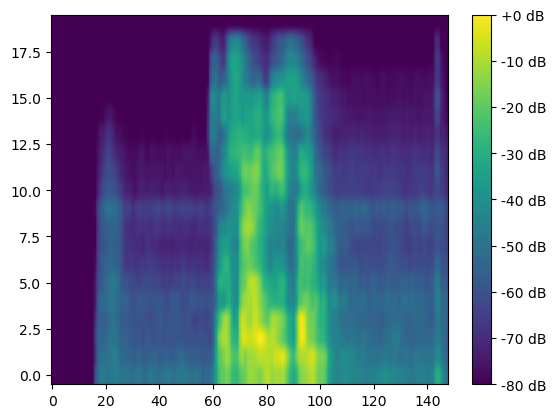

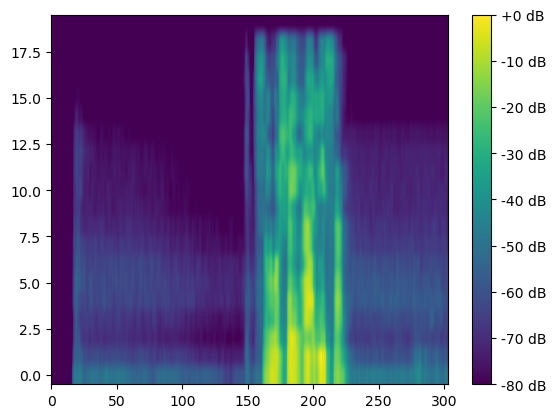

In [9]:
def plot_spectrogram(feature_matrix):
    # Отображение спектрограммы
    plt.imshow(feature_matrix, aspect='auto', origin='lower')

    # Добавление цветовой шкалы
    plt.colorbar(format='%+2.0f dB')

    # Показ графика
    plt.show()

# Пример использования
for feature_matrix in features[:2]:
    plot_spectrogram(feature_matrix)

In [10]:
# Чтение файла targets.tsv
df = pd.read_csv('targets.tsv', sep='\t', header=None, names=['fails_name', 'answer'])

# Вывод первых 5 строк для проверки
print(df.head(10))

                         fails_name  answer
0  5d1f7e43366513a1d0a6ec5640c3dc24       1
1  9a701a4536a05b6610a590a9fe702ed8       1
2  cad0b8547008d1524c1a0e5fd51f9908       1
3  4bbe607e7dc95460e2cc1a6ee5f4dfa6       0
4  30fb32cba90b34af26f3f14f5d636805       0
5  fa33445afe71a6dc18e4881c053da5be       0
6  2f1a399df5f41cf3730253d07d7756ae       0
7  cfb6bb7aa22ae864c2f3e08047b2cd3a       0
8  8de1d8568032a2c5fa8301313b5487bc       1
9  072aec7c0d3ed87387a310fd7c88f9a4       0


In [11]:
nazvania_failov[:5]

['0006238dc99eaf68957dfc81826d1071',
 '0007b9d41374f46f25cb35f13dc97e5e',
 '000ad36ce0dcbc1032a606312d5e787d',
 '0012112033f3f6c687c003cee20d0ba2',
 '00122174f87c115e13f69cd685477387']

In [12]:
df_reordered = df.set_index('fails_name').reindex(nazvania_failov).reset_index()

In [13]:
df_reordered.head(10)

,fails_name,answer
0,0006238dc99eaf68957dfc81826d1071,1
1,0007b9d41374f46f25cb35f13dc97e5e,1
2,000ad36ce0dcbc1032a606312d5e787d,1
3,0012112033f3f6c687c003cee20d0ba2,0
4,00122174f87c115e13f69cd685477387,0
5,00128d3dbe40482e69fa7115a108e122,0
6,0012de492fe2a5811bcc36371ad3a13f,0
7,001418d720f3f38e88a74dff39c46268,1
8,001468e989edc7827ffec11713645524,1
9,0017f6feabf9303491f4febb51584f26,1


In [14]:
import numpy as np

max_len = max(feature.shape[0] for feature in features)
max_width = max(feature.shape[1] for feature in features)

padded_features = np.array([np.pad(feature, 
                                   ((0, max_len - feature.shape[0]),
                                    (0, max_width - feature.shape[1])) , mode='constant') 
                            for feature in features])

knn

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Разделение данных на обучающую и тестовую выборки
X = padded_features.reshape(padded_features.shape[0], -1) #padded_features  # Матрица спектральных признаков с выравниванием
y = df_reordered['answer']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование категориальной переменной в числовой формат
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Обучение модели
model = KNeighborsClassifier(n_neighbors=1500)
model.fit(X_train, y_train_encoded)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5860832137733142


C:\Users\Bulat\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создание модели
model = KNeighborsClassifier()

# Кросс-валидация
scores = cross_val_score(model, X_scaled, y, cv=5)

# Вывод средней точности
print("Average Accuracy:", scores.mean())

C:\Users\Bulat\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Bulat\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Average Accuracy: 0.5127728709693858


C:\Users\Bulat\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создание модели
model = KNeighborsClassifier()

# Задание сетки параметров для перебора
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# Подбор гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_scaled, y)

# Вывод наилучших параметров и точности
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


C:\Users\Bulat\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Bulat\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\Bulat\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Bulat\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

KeyboardInterrupt: 

Просто рандом форест

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Разделение данных на обучающую и тестовую выборки
X = padded_features.reshape(padded_features.shape[0], -1) #padded_features  # Матрица спектральных признаков с выравниванием
y = df_reordered['answer']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.866571018651363


Рандом форест с нормализацией данных

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Разделение данных на обучающую и тестовую выборки
X = padded_features.reshape(padded_features.shape[0], -1) #padded_features  # Матрица спектральных признаков с выравниванием
y = df['answer']  # Целевая переменная

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Обучение модели
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5258249641319943


Рандом форест с нормализацией данныз и кросс-валдацией

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создание модели
model = RandomForestClassifier()

# Кросс-валидация
scores = cross_val_score(model, X_scaled, y, cv=5)

# Вывод средней точности
print("Average Accuracy:", scores.mean())

Average Accuracy: 0.5203062847129452


Подбор параметров

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создание модели
model = RandomForestClassifier()

# Задание сетки параметров для перебора
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Подбор гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_scaled, y)

# Вывод наилучших параметров и точности
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

KeyboardInterrupt: 